In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense


In [28]:
directory = 'fire_dataset/fire_images/'
fire = np.array([np.array(Image.open(directory+filename)) for filename in os.listdir(directory)],dtype = object)


In [29]:
directory = 'fire_dataset/non_fire_images/'
non_fire = np.array([np.array(Image.open(directory+filename)) for filename in os.listdir(directory)],dtype = object)

In [37]:
# np.save('fire.npy',fire, allow_pickle=True)
# np.save('non_fire.npy',non_fire, allow_pickle = True)
fire=np.load('fire.npy',allow_pickle= True)
non_fire=np.load('non_fire.npy', allow_pickle= True)

In [3]:
df = pd.DataFrame(columns=['path','label'])

for dirname, _, filenames in os.walk('fire_dataset/fire_images'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

for dirname, _, filenames in os.walk('fire_dataset/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        # print(os.path.join(dirname, filename))

df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,label
0,fire_dataset/fire_images\fire.414.png,fire
1,fire_dataset/non_fire_images\non_fire.92.png,non_fire
2,fire_dataset/fire_images\fire.246.png,fire
3,fire_dataset/fire_images\fire.264.png,fire
4,fire_dataset/fire_images\fire.516.png,fire
5,fire_dataset/fire_images\fire.299.png,fire
6,fire_dataset/non_fire_images\non_fire.5.png,non_fire
7,fire_dataset/fire_images\fire.654.png,fire
8,fire_dataset/fire_images\fire.27.png,fire
9,fire_dataset/fire_images\fire.269.png,fire


In [4]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,fire_dataset/fire_images\fire.414.png,fire,507,760
1,fire_dataset/non_fire_images\non_fire.92.png,non_fire,563,1000
2,fire_dataset/fire_images\fire.246.png,fire,420,650
3,fire_dataset/fire_images\fire.264.png,fire,267,400
4,fire_dataset/fire_images\fire.516.png,fire,223,396


In [5]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

In [6]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [8]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [9]:
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)



In [11]:
model.fit(x=train_gen,batch_size=32,epochs=15,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])



Epoch 1/15
25/25 [==============================] - 37s 1s/step - loss: 0.3701 - accuracy: 0.8650 - recall: 0.5900 - auc: 0.8854 - val_loss: 0.1555 - val_accuracy: 0.9397 - val_recall: 0.8636 - val_auc: 0.9790
Epoch 2/15
25/25 [==============================] - 37s 1s/step - loss: 0.1452 - accuracy: 0.9425 - recall: 0.8700 - auc: 0.9814 - val_loss: 0.1483 - val_accuracy: 0.9447 - val_recall: 0.7500 - val_auc: 0.9891
Epoch 3/15
25/25 [==============================] - 36s 1s/step - loss: 0.1084 - accuracy: 0.9538 - recall: 0.8900 - auc: 0.9902 - val_loss: 0.1618 - val_accuracy: 0.9246 - val_recall: 1.0000 - val_auc: 0.9887
Epoch 4/15
25/25 [==============================] - 31s 1s/step - loss: 0.1343 - accuracy: 0.9463 - recall: 0.8650 - auc: 0.9834 - val_loss: 0.1101 - val_accuracy: 0.9497 - val_recall: 0.8409 - val_auc: 0.9886
Epoch 5/15
25/25 [==============================] - 34s 1s/step - loss: 0.1029 - accuracy: 0.9613 - recall: 0.9250 - auc: 0.9883 - val_loss: 0.1311 - val_accura

In [12]:
history= model.history.history
px.line(history,title = "Metrics Plot")

In [13]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 4s 608ms/step - loss: 0.0875 - accuracy: 0.9698 - recall: 0.8636 - auc: 0.9952
loss: 0.09
accuracy: 0.97
recall: 0.86
auc: 1.00


In [14]:
!curl https://static01.nyt.com/images/2021/02/19/world/19storm-briefing-texas-fire/19storm-briefing-texas-fire-articleLarge.jpg --output predict.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 50241  100 50241    0     0  50241      0  0:00:01 --:--:--  0:00:01 82497


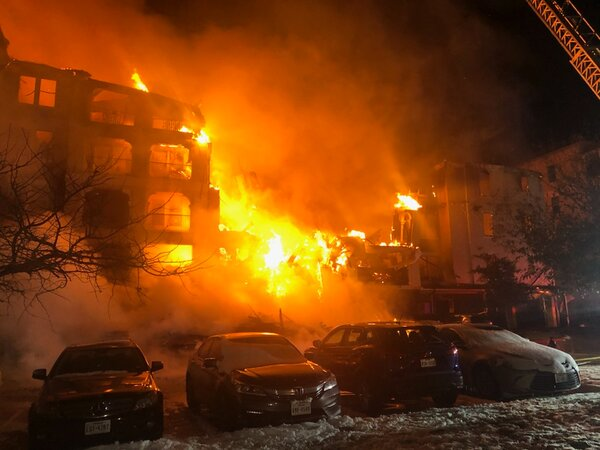

In [15]:
img = image.load_img('predict.jpg')
img


In [16]:


img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)



Image Shape (1, 256, 256, 3)


In [17]:

prediction = int(tf.round(model.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

The predicted value is:  0 and the predicted label is: fire
